In [2]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
import boto3

In [3]:
from analysis import files, collection
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

(6, 64)


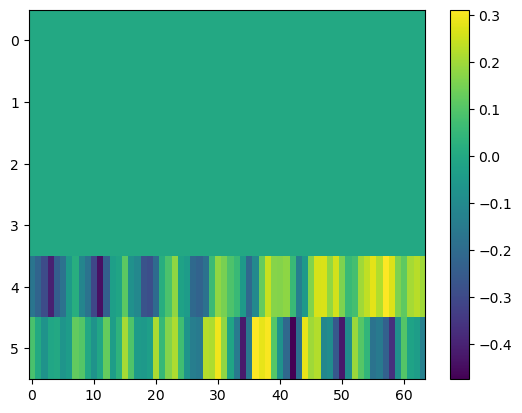

In [7]:
collection_name = "emg_olympics"
subject_name = "alba"
task_name = "center_hold"

c = collection.Collection(collection_name)
s = c.subjects[subject_name]
print(s.decoder.shape)
plt.figure()
plt.imshow(s.decoder, aspect='auto')
plt.colorbar()

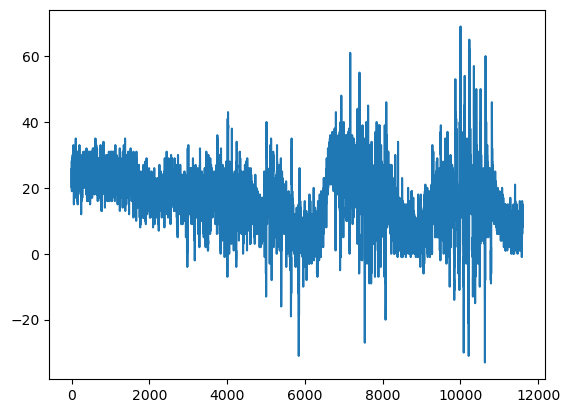

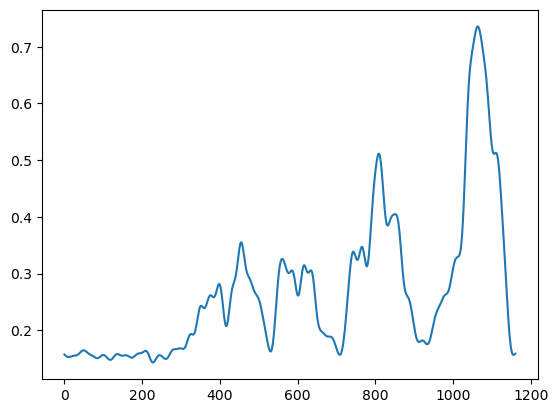

In [26]:
session_num = 1
trial_num = 0
trial = s.tasks["center_hold"].sorted_sessions()[15].sorted_trials()[trial_num]
emg = trial.get_raw_emg()
emg_filt = trial.get_filtered_emg()
plt.figure()
plt.plot(emg[:,1])
plt.figure()
plt.plot(emg_filt[:,1])
plt.show()

In [27]:
print(s.decoder[-2:,:])

[[-0.16901937 -0.221008   -0.29286537 -0.4071523  -0.24025065 -0.17998505
  -0.04758644  0.01948806 -0.11655115 -0.17575617 -0.30770734 -0.4384281
  -0.2309151  -0.03029431 -0.01542938  0.11489928 -0.07840793 -0.10748167
  -0.27437836 -0.28743166 -0.2009085   0.01880842  0.0894166   0.17984867
  -0.02217841 -0.03886431 -0.20508257 -0.22381186 -0.18299815  0.06225614
   0.1820711   0.14998002  0.09318985  0.05810663 -0.04726613 -0.21054961
  -0.10491485  0.12440028  0.24631195  0.16952549  0.16460925  0.17786466
   0.05903073 -0.13665432 -0.04943547  0.1623251   0.26456702  0.26879424
   0.18512343  0.25915357  0.15794492  0.05383701  0.07634109  0.19912305
   0.236936    0.2791208   0.22168854  0.3102502   0.27113384  0.15908062
   0.11576644  0.20611945  0.22696844  0.19896236]
 [ 0.08443862  0.00384574 -0.07037276 -0.00988755 -0.00155675 -0.0638271
  -0.03885963  0.1224969   0.10126431 -0.00309506 -0.07216755 -0.01093465
   0.12456468 -0.03661304  0.03339809  0.20648065  0.09652905 -

Cool, we can load emg signals and subject decoders to produce behavioral trajectories.

The behavioral trajectories unfold within the _controlled subspace_ of the EMG activity, which have an effect on the task variable (the position of the cursor on the screen).
The null space of the projection of the EMG into the behavior space defines the _uncontrolled subspace_: muscle activations which have no effect on cursor position.

We want to compute these two subspaces, and then compare the variance within each to understand whether subjects are more or less variable in their task-relevant or task-irrelevant dimensions. Our hypothesis, in concordance with the literature, is that subjects will be less variable in controlled dimensions.

[Here's](https://math.stackexchange.com/questions/1318637/projection-of-a-vector-onto-the-null-space-of-a-matrix) a link to a discussion about computing the null space projection.


D @ e = 0

projector matrix = D.T @ (D @ D.T) @ D @ e 

the "projector" matrix which projects onto the image of A^T because P^2 = P and PA^T = A^T

In [28]:
def compute_null_task_space_components(sample: np.array, mapping: np.array):
    projector = mapping.T@np.linalg.inv(mapping@mapping.T)@mapping
    task = projector@sample
    null = (np.eye(sample.shape[0]) - projector)@sample
    return task, null 

# test
compute_null_task_space_components(sample=np.array([[1,1,1,1]]).T, mapping=np.eye(4)[-2:,:])

(array([[0.],
        [0.],
        [1.],
        [1.]]),
 array([[1.],
        [1.],
        [0.],
        [0.]]))

## variance of the null and task space projections

(64, 1161) (64, 1161)


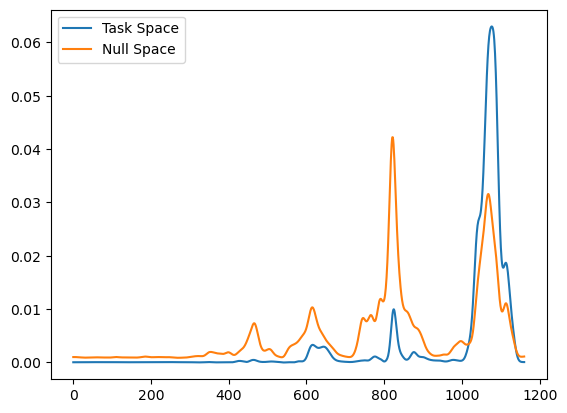

In [29]:
task, null = compute_null_task_space_components(sample=emg_filt.T, mapping=s.decoder[-2:,:])
print(task.shape, null.shape)

# 
plt.plot(np.var(task,axis=0), label="Task Space")
plt.plot(np.var(null, axis=0), label="Null Space")
np.sum(np.var(task, axis=0)), np.sum(np.var(null, axis=0))
plt.legend()

Compare this to natural movement, calibration -- NMF should be extracting more variance in task relevant subspace

Need a summary stat here to compare across trials-- not sure what this is yet.